In [126]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import datetime
import glob
from sklearn import datasets, linear_model, ensemble, neural_network
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from pathlib import Path

DOWNLOAD_DIR = 'G:/Meine Ablage/LVA/scientific computing/lecture-scientific-computing/lecture06-pandas/data'



In [216]:
def read_single_csv_entso_e(file):
    return pd.read_csv(file, sep='\t', encoding='utf-16')


def load_complete_entso_e_data(directory):

    pattern = Path(directory) / '*.csv'
    files = glob.glob(str(pattern))
    
    print(f'Concatenating {len(files)} csv files...')
    
    each_csv_file = [read_single_csv_entso_e(file) for file in files]
    data = pd.concat(each_csv_file, ignore_index=True)

    data["DateTime"] = pd.to_datetime(data["DateTime"])

    data = data.sort_values(by=["AreaName", "DateTime"])
    
    power_demand = power_demand.set_index("DateTime")

    return data


power_demand = load_complete_entso_e_data(DOWNLOAD_DIR)


Concatenating 68 csv files...


In [217]:
power_demand = power_demand.set_index("DateTime")

In [94]:
def get_country_data(data, country):
    ret_data = data[data["AreaName"] == country]
    #ret_data = ret_data.set_index("DateTime")
    return ret_data

power_demand_at = get_country_data(power_demand, "Austria")
power_demand_at_hourly = power_demand_at.resample("1h").mean()

## Model fitting

What does it mean to fit a model?

We want to predict or explain some $Y$ by other varialbes $X1, X2, ... Xn$

In Machine Learning, emphasis is on predicting, while standard regression analysis focuses more on explanations.

Standard regression analysis has the following form:

$Y=X1 + X2 + X3 + ... + Xn + \epsilon$, $\epsilon$ being the error term.

It therefore assumes a linear, additive relationship between input variables. Non-linear relationships can be modelled by transforming input variables, e.g. assuming that the relationship between $Y$ and $X$ is quadratic, one can do the following $X1_{t}=X1^2$ and $Y=X1_{t}$

However, a functional form has to be specified. What if this form is unknown? Other machine learning algorithms such as e.g. neural networks can discover any functional form between input and output without specifying it. So a neural network can, by itself, discover $Y=X^2$. This comes at some cost: standard statistical tools such as test statistics etc. do not work and it the model is a black-box.

## Fitting power demand

We create a training, a validation, and a test dataset.

The training dataset is used to minimize the error between input and output and therefore determine model parameters. It should not be used to assess the quality of your model, as the parameters may be overfitted to your data. For that purpose, validation data is used. However validation data may be implicitly used to optimize some (meta-)parameters of your model, thus validation data also becomes prone to overfitting. One should therefore have a final test data-set to understand model quality. 

Our predicted value Y is the hourly demand.

In [189]:
test_data_set = power_demand_at_hourly['2019-05-01':]
training_data_set = power_demand_at_hourly[:'2019-04-30']

In [194]:
# Our predicted variable Y is the hourly load
def get_Y(data):
    Y = np.array(data["TotalLoadValue"]).reshape(-1, 1)
    
    return Y

Y = get_Y(training_data_set)

In [195]:
Y

array([[5493.2],
       [5341.2],
       [5335.5],
       ...,
       [5057.8],
       [4767.8],
       [4485.4]])

Our predictor variables (or features) are simply months, weekdays, and hours. 

In [196]:
def get_X(data, has_trend = False):

    monthly_dummies = np.array(pd.get_dummies(
        data.index.month))[:, :11]

    weekday = np.array(pd.get_dummies(
        data.index.weekday))[:, :6]

    hour = np.array(pd.get_dummies(
        data.index.hour))[:, :23]

    trend = np.arange(0, len(hour)).reshape(-1, 1)
    
    X_out = np.append(monthly_dummies, weekday, axis=1)
    X_out = np.append(X_out, hour, axis=1)
    
    if(has_trend):
        X_out = np.append(X_out, trend, axis=1)
        
    return X_out
        
X = get_X(training_data_set)
X_w = get_X(test_data_set)    

In [187]:
X.shape

(38665, 40)

In [188]:
X_w.shape

(9168, 40)

Joining them all together.

In [197]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)


Let's put this into a linear model.

In [198]:
# regr = linear_model.LinearRegression(fit_intercept = False)
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)

# The coefficients
print('Coefficients: \n', regr.coef_)

pred = regr.predict(X_test)

r2_score(Y_test, pred)


Coefficients: 
 [[  246.20743699    87.06027209  -646.68511525 -1724.50115091
  -1222.25935744 -1111.58777182 -1131.52885476 -1251.07413244
  -1014.92040186  -732.94982881  -168.54525132  1386.38007807
   1504.86664155  1523.61902719  1450.19739438  1294.41116073
    376.72644395  -160.58800766  -267.7161069   -264.02865232
     20.74331136   725.06486397  1442.91557624  1975.61507807
   2166.13578835  2203.94077849  2307.66862922  2179.26910789
   2026.91584608  1879.20475047  1810.3301384   1843.68452964
   1901.66954051  2119.44658546  2005.37281061  1743.64199337
   1337.35514224   992.09450008   650.63291915   307.49886138]]


0.8113558302416457

In [144]:
# regr = linear_model.LinearRegression(fit_intercept = False)
regr = ensemble.RandomForestRegressor()

# Train the model using the training sets
regr.fit(X_train, Y_train.reshape(-1, ))

pred = regr.predict(X_test)

r2_score(Y_test, pred)


0.8205348169885491

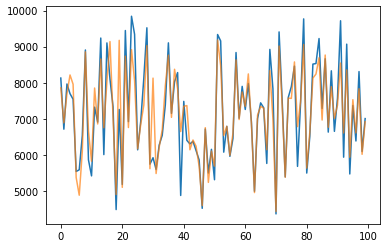

In [146]:
plt.plot(Y_test[1000:1100])
plt.plot(pred[1000:1100], alpha=0.7)

In [147]:
# regr = linear_model.LinearRegression(fit_intercept = False)
regr = neural_network.MLPRegressor(max_iter=200)

# Train the model using the training sets
regr.fit(X_train, Y_train.reshape(-1, ))

# The coefficients

pred = regr.predict(X_test)

r2_score(Y_test, pred)


C:\Users\jo\anaconda3\envs\scientific-computing\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.7821348611089012

In [200]:
# and on our working data set?
X_w = get_X(test_data_set)
Y_w = get_Y(test_data_set)

pred_w = regr.predict(X_w)
r2_score(Y_w, pred_w)

0.8101647208097777

What does the intercept of the regression tell us?

In [58]:
regr.intercept_

array([5027.00423503])

Let's predict with the model on the training data...

How does it look like?

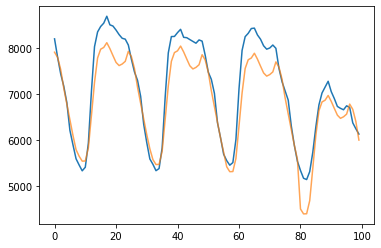

In [202]:
plt.plot(Y_w[1000:1100, :])
plt.plot(pred_w[1000:1100, :], alpha=0.7)

Pretty cool for such a simple model. How does it look over the whole range?

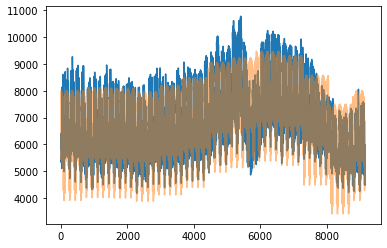

In [203]:
plt.plot(Y_w)
plt.plot(pred_w, alpha=0.5)

And R^2?

In [218]:
def calc_residual(power_demand, country):
    
    data = get_country_data(power_demand, country).resample('1h').mean().interpolate()
    
    test_data_set = data.copy()['2019-05-01':]
    training_data_set = data.copy()[:'2019-04-30']
    
    # Our predicted variable Y is the hourly load

    Y = get_Y(training_data_set)
    
    X = get_X(training_data_set)
    
    Y_pred = get_Y(test_data_set)
    
    X_pred = get_X(test_data_set)
    
    # regr = linear_model.LinearRegression(fit_intercept = False)
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X, Y)
    
    pred = regr.predict(X_pred)
    
    test_data_set["Residuals"] = (Y_pred - pred) / pred
    
    test_data_set["Residuals"].resample('1m').mean().plot()
    
    


    
    
    
    

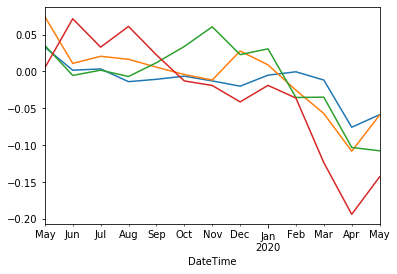

In [222]:
calc_residual(power_demand, "Germany")
calc_residual(power_demand, "Austria")
calc_residual(power_demand, "Portugal")
calc_residual(power_demand, "Italy")



## Exercise 5

Before you do the exercise, let's vote. What expectation do you have when comparing the mean of Y and of pred?

Now, calculate the mean of the two values.

## Exercise 6

Now let's work on the results of the regression. What do coefficients tell us? 

Now plot the dummies for months, weekdays and hours seperately.


In [ ]:
coefs = np.array(regr.coef_).T

# months

In [ ]:
# weekdays

In [ ]:
# hours

## Exercise 7

How do residuals look like now, i.e. the difference between actual value and prediction? 

Plot the residuals.